<h1><u>Golden Process Route Identification</u></h1>
<p style="text-align:right;">
   <b>Mentored by</b> - Vikas Verma ( Semi Conductor Limited, ISRO branch )
   <br>
   <b>Submitted by</b>- Dipanshu Verma (IIT Mandi, Btech. Computer Science)
</p>
<h3>Description</h3>
<p>Increasing the yield effeciency is a requirement that is very difficult to pursue manually, as it requires manual effort and considerable time window to see the results. Hence, we try to build a model (based on DeepLearning) that can carry out the process many times faster and without the involvemnet of any real time queries on the processes. All we require is the data collected,pertaining to parameters and objects , prior to carrying out the processes/unit steps. However, the proposed model can only be applied on a single process for its optimisation</p>

<hr>

<h3>Methodology Proposed</h3>
<br>
The following steps were proposed to carry out the research on the data
<ol>
    <li> <b>Finding</b> out the process on which the optimisation has to be applied</li>
    <li> <b>Fetching</b> the data from sql table into csv format, (as python is very comfortable with CSVs')</li>
    <li> <b>Analysing</b> the selected process to find:
        <ul>
            <li>the mean and the standard deviations for each parameter id
            <li>the expected distribution of the parameters for the process (assuming the process parameters to follow a gaussian distribution).
            <li>Graphing the results as histograms/line_curves to outline the presence of outliers
            <li>from the above insights, finding out outlier data pertaining to the measured values of the given data.
        </ul>
    </li>
    <li> Removing the outliers. normalising the data and other <b>preprocessing</b> techniques to clean data. Finally, <b>learning</b> the effect of input parameters on the ouput.
    <li> From the weights and relation obtained varying the input parameters through a range of LSL to USL and <b>find its value for optimal output</b> (best yield)</li>
        <li><b>output the final values</b> that should be applied for the process.</li>
</ol>
<p> We thus will list down the above mentioned steps in a greater detail in the following points.</p>


<h3><u>Note: environment</u></h3>
    <p>
        the code presumes you have python3 installed on your machine.<br>
        The following python3 libraries are required to execute the cells.
    <ul>
        <li>
            <code>pandas</code>
        </li>
        <li>
            <code>numpy</code>
        </li>
        <li>
            <code>scipy</code>
        </li>
        <li>
            <code>matplotlib</code>
        </li>
    </ul>
    </p>
    <p>you may simply run <code>pip install requirements.txt</code> to ensure the libraries are installed.</p>

<h2>1. Process for carrying out research</h2>
<p> The process chosen to carry out this research was "Product Flow 1.8V/3.3V w". As this process was quite useful and had the scope to be imporved our further analysis assumes all other data is only related to this process.</p>
<hr>
<h2>2. Fetching data from sql database</h2>
<p> The following command on executing fetches the required data for further analysis. The output of the data is stored in <code>data/data.csv</code> </p>

```mysql
SELECT A.LotID,A.DeviceID,A.ProcessID , C.OperationID, C.ParameterId, C.MeasuredValue as MV, C.WaferNo, E.UpperHoldValue as USL, E.LowerHoldValue as LSL, E.UpperControlLimit as UCL, E.LowerControlLimit as LCL
FROM
  LLotStart A
  inner join LOperationMeasuredValueRaw C on C.LotID = A.LotID
  inner join ParameterIdForRnQA1 B on B.ParameterId  = C.ParameterId
  inner join LOperationLimits E on E.OpParameterID = B.ParameterId and E.OperationID = C.OperationID
  inner join LOperationParameterUnit F on F.OpParameterId = B.ParameterId and F.OperationID = C.OperationID
WHERE A.LotID like 'F%' and ProcessID = 'Product Flow 1.8V/3.3V w'	
order by C.ParameterId, LotID desc
```

<p>However, the data obtaned in this manner has a lot of whitespacing issues and other irregularities, lets clean the data a little bit. The following python snippet <code>initial_formatting.py</code> does this task effeciently

In [ ]:
#---preprocessing the spacing error in the file------

#-----extracting data-------
file = open('data/data.csv','r')
data = file.read()
file.close()

#-------formatting data------------
data = data.split('\n')
for i in range(0,len(data)):
    data[i]=data[i].split(',')
    for j in range(len(data[i])):
        data[i][j]=data[i][j].strip()
data[0][0]='lotid'


#----writing to the final file for csv--------
file=open('data/processed_data.csv','w')
s=''
for i in range(0,len(data)-1):
    s+=data[i][0]
    for j in range(1,len(data[i])):
        s+=','+data[i][j]
    s+='\n'
file.write(s)
file.close()


<h2>3. Analysing</h2>
<p>  The above cell would result in <code>data/processed_data.csv</code>. As mentioned above we follow the steps indicated below to further analyse the so created data.</p>
<hr>

<h3>Finding mean,standard deviations for each parameter id</h3>
<p> The following python snippet does the entire work of finding</p>
<p> Some essential points to note:
    <ul>
        <li> Since the provided data does not contain the target value we assume target value to be around the mean for that will remain same throughout for a given parameter under the process.</li>
        <li> The mean calculated is only wrt to the given process so it includes all the sum of all the values of measured value for a given parameter and dividing by total occurances, but the scope of domain is only the process included, as the same parameter might have been used for other process too, but will not be considered in these means. The same goes for the calculated standard deviations.</li>

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 17 21:06:59 2020

@author: dipanshu
"""
import pandas as pd
import numpy as np

data = pd.read_csv('data/processed_data.csv')

parameter_grouped_data = data.groupby('parameterid')
mv_stdev = parameter_grouped_data.mv.std()
mv_mean = parameter_grouped_data.mv.mean()

for i in range(len(data)):
    data.at[i,'mean']=mv_mean[data.loc[i]['parameterid']]
    data.at[i,'standard_dev']=mv_stdev[data.loc[i]['parameterid']]
    data.at[i,'target_value']=int(mv_mean[data.loc[i]['parameterid']])
    
data.to_csv('data/data_w_mean_std.csv', index=False)


<h3>Expected distribution of the parameters for the process</h3>
<p> Some essential points to note:
    <ul>
        <li> we have assumed the data to follow a gaussian distribution for each parameter. The gaussian distribution has a mean and a standard deviation as its parameters. (Also called bell shaped curve)</li>
        <li>
            The distribution has the following distribution, where mu=mean and sigma=standard_deviation
        </li>

![gaussian.png](gaussian.png)
<hr>

<h3>Graphing the results as histograms/line_curves to outline the presence of outliers</h3>
<p> The following python snippet does the entire work of graphing the various plots</p>
<p> Some essential points to note:
    <ul>
        <li> Some parameters have a very large value of USL inserted. These values are dummy values and hence do not occur in the provided artist for the graph. the graph covers a range on the x axis from (mean-10*stdev) to (mean+10*stdev)</li>

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 20 11:35:16 2020

@author: dipanshu
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

data = pd.read_csv('data/data_w_mean_std.csv')

parameter_grouped_data = dict(list(data.groupby('parameterid')))
parameters = list(parameter_grouped_data.keys())
for index,parameter in enumerate(parameters):
    plt.figure(figsize=[12,6])
    
    mean=parameter_grouped_data[parameter]['mean'].mean()
    standard_dev=parameter_grouped_data[parameter].standard_dev.mean()
    target = parameter_grouped_data[parameter].target_value.mean()
    if(mean==target):
        target+=1
    
    if(standard_dev==0):
        print('data not enough... aborting for',parameter)
        continue
    
    usl = parameter_grouped_data[parameter].usl.mean()
    lsl = parameter_grouped_data[parameter].lsl.mean()
    
    plt.axvline(usl,linestyle='dashed',label='USL ='+str(usl),color='b')
    plt.axvline(lsl,linestyle='dashed',label='LSL ='+str(lsl),color='g')
    plt.axvline(mean,linestyle='dashed',label='mean ='+str(mean),color='red')
    plt.axvline(target,linestyle='dashed',label='target value ='+str(target),color='yellow')
    
    n,bins,patches = plt.hist(parameter_grouped_data[parameter].mv, align='mid',\
                              color=(0.4, 0.6, 0.6, 1), edgecolor='black',density=True)
    for i in range(len(bins)-1):
        bar_val = (bins[i]+bins[i+1])/2
        if(bar_val<lsl or bar_val>usl):
            patches[i].set_fc('r')
    
    bell_x = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
    bell_y = n
    expected_x = np.linspace(mean-standard_dev*5,mean+standard_dev*5,1000)
    expected_y = st.norm(mean,standard_dev).pdf(expected_x)
    
    plt.plot(bell_x,bell_y,linestyle='dashed',color='black',label='lineCurve')
    plt.plot(expected_x,expected_y,color='red',label='expected bell curve')
    plt.xlim([mean-10*standard_dev,mean+10*standard_dev])
    
    plt.legend()
    plt.savefig('graphs/'+str(parameter)+'.png')
    plt.close()
    print('progress: ',round((index/len(parameters))*100,2),'graphed',parameter,'...')

print('process has completed... thank you for your patience =)')


<p><b>One of the graphs with correct data looks as follows</b></p>
<p>Key points to note
    <ul>
        <li> where the x axis is the measured values while the y axis is the distribution (fraction of the occurence of that bin)</li>
        <li> the bars in green represent that these are acceptable values, while those in red represent non-acceptable values</li>
    </ul>
<p>

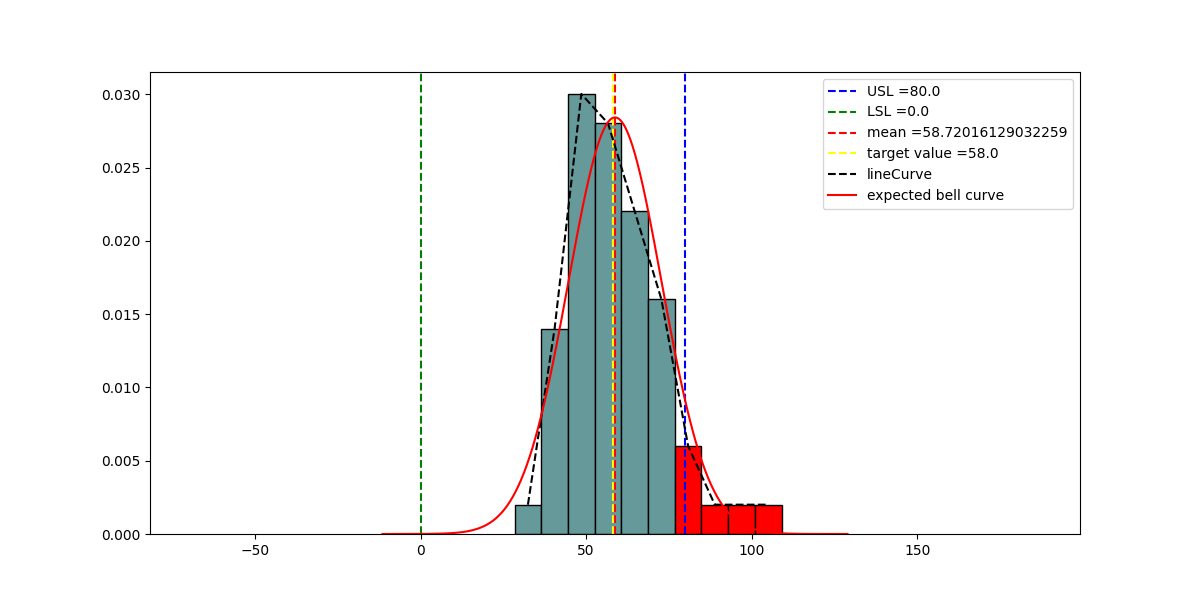

<h3>Finding out outlier data pertaining to the measured values of the given data.</h3>
<p> The following python snippet does the entire work of outputing the csv containing info related to those outliers</p>

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 21 12:32:11 2020

@author: dipanshu
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

data = pd.read_csv('data/data_w_mean_std.csv')

parameter_grouped_data = dict(list(data.groupby('parameterid')))
parameters = list(parameter_grouped_data.keys())

outliers = pd.DataFrame(columns=data.columns)

for parameter in parameters:
    df = parameter_grouped_data[parameter]
    mean=parameter_grouped_data[parameter]['mean'].mean()
    standard_dev=parameter_grouped_data[parameter].standard_dev.mean()
    usl = parameter_grouped_data[parameter].usl.mean()
    lsl = parameter_grouped_data[parameter].lsl.mean()
    outlier_df = df.loc[(df.mv>usl) | (df.mv<lsl)]
    outliers=pd.concat([outliers,outlier_df],ignore_index=True)
    
outliers.to_csv('data/outlier_data.csv',index=False)


In [5]:
#-------displaying few above rows of the created dataset with outlier values-----------
import pandas as pd
data = pd.read_csv('data/outlier_data.csv')
data.head(3)


,lotid,deviceid,processid,operationid,parameterid,mv,wafer,usl,lsl,ucl,lcl,mean,standard_dev,target_value
0,F19320003.F1,SCL19MP0021_Process_R4,Product Flow 1.8V/3.3V w,MDF_YEDR1.033,CP_Pad_NIT_0.2_Delta,352.0,1,300.0,-125.0,125.0,-125.0,59.825243,48.404227,59.0
1,F18190003.F1,SCL18MP0015,Product Flow 1.8V/3.3V w,MWE_YEDR1.041,CP_Pad_Scan_0.16,710.0,1,400.0,0.0,400.0,0.0,244.228288,207.268746,244.0
2,F18190003.F1,SCL18MP0015,Product Flow 1.8V/3.3V w,MWE_YEDR1.041,CP_Pad_Scan_0.16,686.0,2,400.0,0.0,400.0,0.0,244.228288,207.268746,244.0


<h2><u>Future Goals</u></h2>
<p>Due to a very small amount of "VALID" data for each parameter the future activites depend on the availablity of better amounts of data with correct information implanted. However the above piece of the report would go same once a cleaner version of data is available.<p>
<p>It would be essential to again list down the activities we seek for the future provided we get the valid forms of the required data
    <ul>
        <li> Removing the outliers. normalising the data and other <b>preprocessing</b> techniques to clean data. Finally, learning the effect of input parameters on the ouput.
    <li> From the weights and relation obtained varying the input parameters through a range of LSL to USL and <b>find its value for optimal output</b> (best yield)</li>
        <li><b>output the final values</b> that should be applied for the process.</li>
     </ul>
</p>

<h2>References</h2>
<p>  
[1] https://www.greycampus.com/blog/quality-management/how-to-measure-process-capability-and-process-performance <br>
[2] https://www.spcforexcel.com/knowledge/process-capability/cpk-alone-not-sufficient <br>
[3] https://www.isixsigma.com/tools-templates/capability-indices-process-capability/cp-cpk-pp-and-ppk-know-how-and-when-use-them/ <br>
[4] https://blog.minitab.com/blog/statistics-and-quality-data-analysis/cp-and-cpk-two-process-perspectives-one-process-reality <br>
</p>